In [847]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [848]:
import pandas as pd

In [849]:
odf = pd.read_csv("https://npg-ds.s3.amazonaws.com/bike_sharing.csv")
odf.copy()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [850]:
# copy the dataframe from later usage
df = odf.copy()

The dataset has the following features:

1. Datetime: hourly date + timestamp
2. Season:
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter
3. Holiday: whether the day is considered a holiday
4. Workingday: whether the day is neither a weekend nor holiday
5. Weather:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
6. Temp: temperature in Celsius
7. Atemp: "feels like" temperature in Celsius
8. Humidity: relative humidity
9. Windspeed: wind speed
10. Casual: number of non-registered user rentals initiated
11. Registered: number of registered user rentals initiated
12. Count: number of total rentals

Let's see some statistics on the data.

In [851]:
df.copy().describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Let's now start checking for some initial statistics about our dataset. For instance we could check for null values per feature:

In [852]:
df.copy().isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Now let's convert the dates into timestamps.

In [853]:
# those values represent the composition of the count
# we won't have them in reality
df.drop("casual", axis=1, inplace=True)
df.drop("registered", axis=1, inplace=True)


df['datetime'] = pd.to_datetime(df['datetime'])

# We'll only use year, month, hour, and day of week as it has the granularity we want
# we use day of week instead of the day number because the demand we'll probably
# match better with the day of week than with an specific day in the month
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df.drop("datetime", axis=1, inplace=True)
df.copy()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,day_of_week
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,2
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,20,2
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,21,2
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,22,2


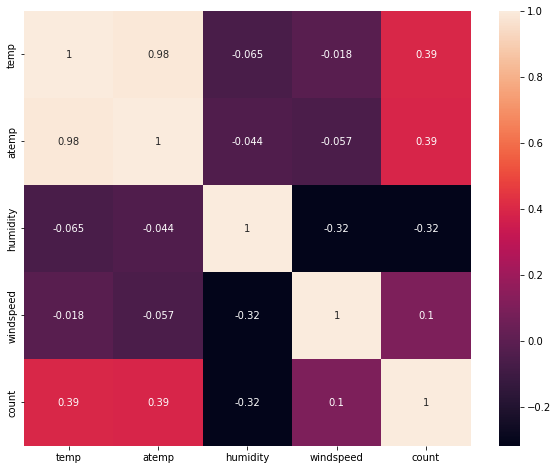

In [854]:
import matplotlib.pyplot as plt
import seaborn as sns


correlation_matrix = df[["temp", "atemp", "humidity", "windspeed", "count"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True);

From the correlation matrix we can observe:

1. Temp and Atemp are highly correlated. This make sense as we can expect people to to have a "feel" for the temperature close to the actual number. We are okay using one of them. Let's keep `temp` and drop `atemp`
2. Windspeed and Humidity are highly correlated fields, we'll keep `humidity` for now and drop `windspeed`.

Now let's try to compare how our categorical data compares to our target, `count`.

<AxesSubplot:xlabel='season', ylabel='count'>

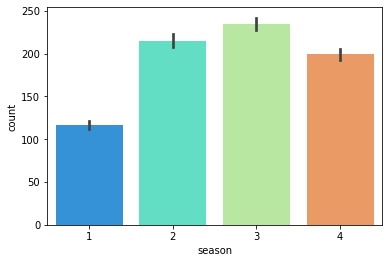

In [855]:
sns.barplot(data=df, x='season', y='count', palette='rainbow')

We can see some variation with the season, it increases during summer and fall (2 and 3) and decreases in winter and spring. It's clear we are going to need to add the season as it has a real impact in demand.

<AxesSubplot:xlabel='holiday', ylabel='count'>

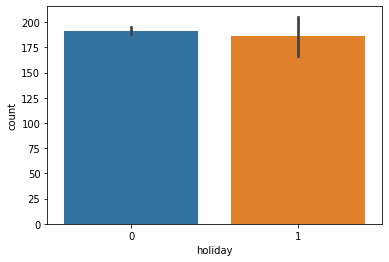

In [856]:
sns.barplot(data=df, x='holiday', y='count')

There is some impact, the demand was high during regular days and it decreases if the day is a holiday.

<AxesSubplot:xlabel='workingday', ylabel='count'>

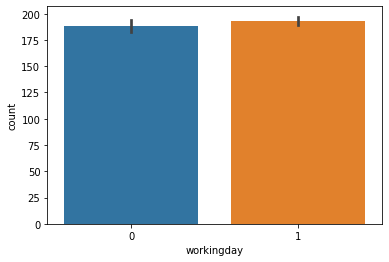

In [857]:
sns.barplot(data=df, x='workingday', y='count')

Seems that the demand is similar for regular working days vs weekends plus holidays. We can ignore this as it doesn't have too much impact on the demand.

<AxesSubplot:xlabel='weather', ylabel='count'>

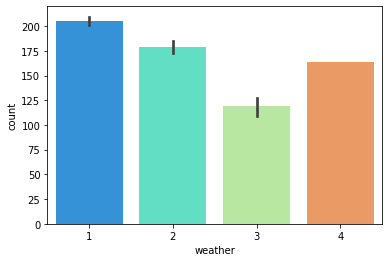

In [858]:
sns.barplot(data=df, x='weather', y='count', palette='rainbow')

Weather clearly changes demand, we'll want to use this feature.

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

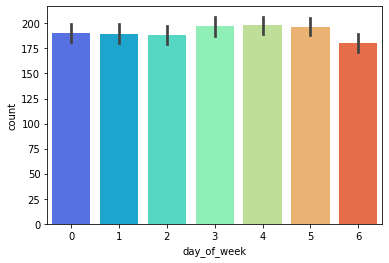

In [859]:
sns.barplot(data=df, x='day_of_week', y='count', palette='rainbow')

<AxesSubplot:xlabel='month', ylabel='count'>

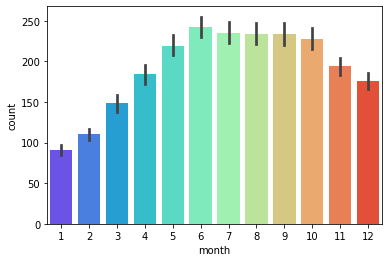

In [860]:
sns.barplot(data=df, x='month', y='count', palette='rainbow')

We can clearly see that some months has higher demand than other, it probably also related to the seasons. We'll keep it for now.

<AxesSubplot:xlabel='hour', ylabel='count'>

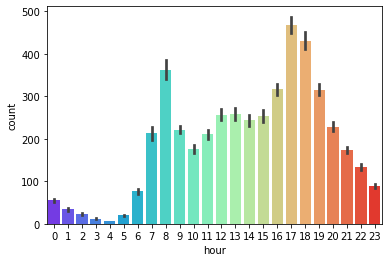

In [861]:
sns.barplot(data=df, x='hour', y='count', palette='rainbow')

Clearly demand is higher at on the early morning and in the afternoon, you could say after work.

<AxesSubplot:xlabel='year', ylabel='count'>

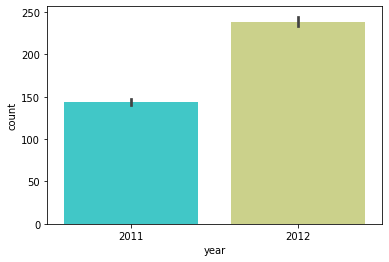

In [862]:
sns.barplot(data=df, x='year', y='count', palette='rainbow')

We don't want to use the years, the count for those could be smaller just because the evolving user base. Also we also only have data of two years, so we can't really get much out of this data. We'll drop it for now.
Let's know apply the changes mentioned to the dataset.

In [863]:
df.drop("windspeed", axis=1, inplace=True)
df.drop("atemp", axis=1, inplace=True)
df.drop("workingday", axis=1, inplace=True)
df.drop("year", axis=1, inplace=True)
df.drop("day_of_week", axis=1, inplace=True)
df.drop("humidity", axis=1, inplace=True)

Now that we decided which are the initial features we'll want to use, let's know encode the categorical data. For this we'll use Target Encoding.

In [864]:
from category_encoders import TargetEncoder

# encode categorical data
df = TargetEncoder(cols=["season", "holiday", "weather", "month", "hour"]).fit_transform(df, df["count"])
df.copy()

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,season,holiday,weather,temp,count,month,hour
0,116.343261,191.741655,205.236791,9.84,16,90.366516,55.138462
1,116.343261,191.741655,205.236791,9.02,40,90.366516,33.859031
2,116.343261,191.741655,205.236791,9.02,32,90.366516,22.899554
3,116.343261,191.741655,205.236791,9.84,13,90.366516,11.757506
4,116.343261,191.741655,205.236791,9.84,1,90.366516,6.407240
...,...,...,...,...,...,...,...
10881,198.988296,191.741655,205.236791,15.58,336,175.614035,315.278509
10882,198.988296,191.741655,205.236791,14.76,241,175.614035,228.517544
10883,198.988296,191.741655,205.236791,13.94,168,175.614035,173.370614
10884,198.988296,191.741655,205.236791,13.94,129,175.614035,133.576754


Let's identify and remove outliers.

In [865]:
from sklearn.neighbors import LocalOutlierFactor

df["outlier"] = LocalOutlierFactor(n_neighbors=570).fit_predict(df)
print(f"Number of outliers: {len(df[df.outlier == -1])}")
df = df[df.outlier == 1]
df.drop("outlier", axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)
df.copy()

Number of outliers: 226


,season,holiday,weather,temp,count,month,hour
0,116.343261,191.741655,205.236791,9.84,16,90.366516,55.138462
1,116.343261,191.741655,205.236791,9.02,40,90.366516,33.859031
2,116.343261,191.741655,205.236791,9.02,32,90.366516,22.899554
3,116.343261,191.741655,205.236791,9.84,13,90.366516,11.757506
4,116.343261,191.741655,205.236791,9.84,1,90.366516,6.407240
...,...,...,...,...,...,...,...
10655,198.988296,191.741655,205.236791,15.58,336,175.614035,315.278509
10656,198.988296,191.741655,205.236791,14.76,241,175.614035,228.517544
10657,198.988296,191.741655,205.236791,13.94,168,175.614035,173.370614
10658,198.988296,191.741655,205.236791,13.94,129,175.614035,133.576754


Now we can start training our model. First let's split our data in test and training.

In [866]:
from sklearn.model_selection import train_test_split

# split data for train and test
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

# split into features and labels
training_features = training_data.copy()
training_features = training_features.drop("count", axis=1)
training_labels = training_data["count"]

# split into features and labels
testing_features = pd.DataFrame(testing_data.copy())
testing_features = testing_features.drop("count", axis=1)
testing_labels = pd.DataFrame(testing_data["count"])

training_features.reset_index(inplace=True, drop=True)
training_labels.reset_index(inplace=True, drop=True)
testing_features.reset_index(inplace=True, drop=True)
testing_labels.reset_index(inplace=True, drop=True)

training_features

,season,holiday,weather,temp,month,hour
0,198.988296,191.741655,205.236791,14.76,193.677278,133.576754
1,215.251372,191.741655,205.236791,22.96,219.459430,133.576754
2,116.343261,191.741655,205.236791,4.10,90.366516,213.116484
3,234.417124,191.741655,205.236791,36.90,235.325658,254.298246
4,198.988296,191.741655,205.236791,13.12,193.677278,315.278509
...,...,...,...,...,...,...
8523,234.417124,191.741655,205.236791,31.16,234.118421,210.674725
8524,234.417124,191.741655,205.236791,28.70,235.325658,468.765351
8525,198.988296,191.741655,178.955540,14.76,175.614035,19.767699
8526,116.343261,191.741655,178.955540,20.50,148.169811,243.442982


Now we can train our model. In this case we will use linear regression.

In [871]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor

random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=2000, num=30)],
    "criterion": ["mse", "mae"],
    'max_features': ['sqrt', "log2"],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(training_features, training_labels)
rf_random.best_params_

KeyboardInterrupt: 

In [846]:
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# train model
rfr = RandomForestRegressor()
rfr.fit(training_features, training_labels)

training_score = rfr.score(training_features, training_labels)
test_score = rfr.score(testing_features, testing_labels)

print(f"Training Score: {training_score}")
print(f"Test Score: {test_score}")


result = DataFrame()
result["actual"] = rfr.predict(testing_features)
result["expected"] = testing_labels
result

Training Score: 0.8634700389842518
Test Score: 0.6587788224810882


,actual,expected
0,214.035500,150
1,150.680000,179
2,562.633667,809
3,2.939429,3
4,47.362000,53
...,...,...
2127,368.125369,308
2128,243.719893,140
2129,4.372968,30
2130,74.932833,120
